# ELTDM Project for ENSAE

Reinforcement learning is very trendy nowadays, especially ever since Google's AlphaGo beat some of the worlds best Go players. How did they manage to teach a computer how to play a game, and more importantly, how to win it ?

The research team at Deepmind showed AlphaGo a large number of strong amateur games to help it develop its own understanding of what reasonable human play looks like. Then they had it play against different versions of itself thousands of times, each time learning from its mistakes and incrementally improving until it became immensely strong, through a process known as reinforcement learning.

We won't be dealing with the game of Go in this project, but we did use OpenAI Gym, a website that provides ready-to-use classic reinforcement learning environments. The OpenAI Gym provides many standard environments for people to test their reinforcement algorithms. These environments include classic games like Atari Breakout and Doom, and simulated physical environments like CartPole, the example used in this project.

Below is a part of code that illustrates in Jupyter what the CartPole example game looks like. We need to stabilize the pole for as long as possible, while staying in a certain range.


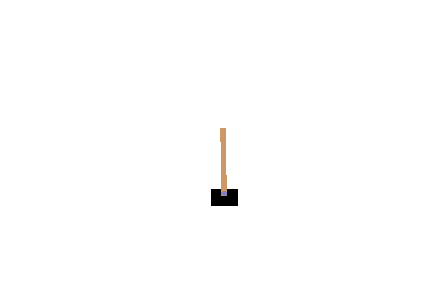
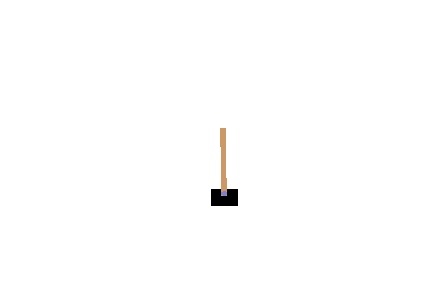
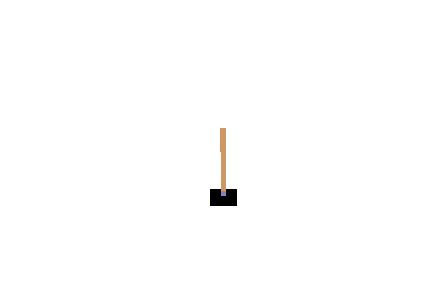
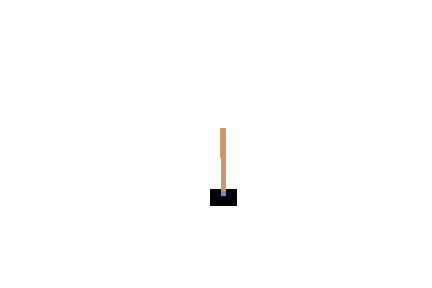
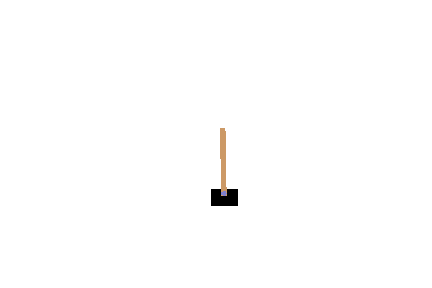
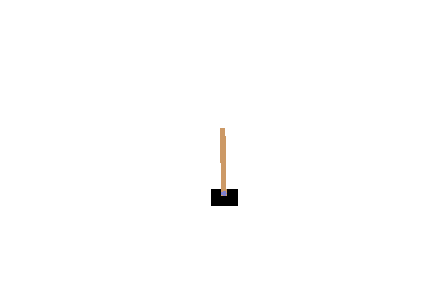
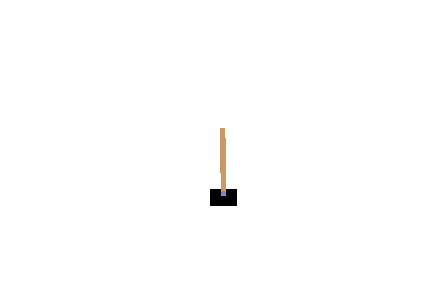
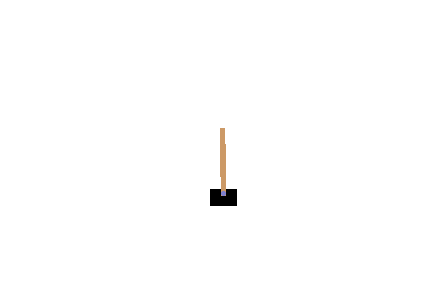
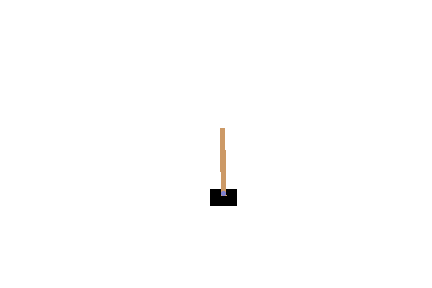
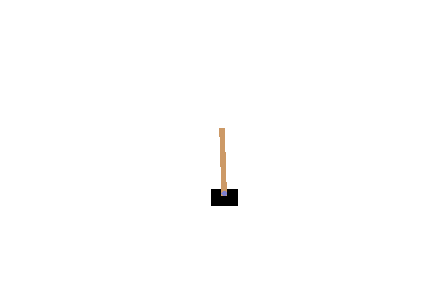
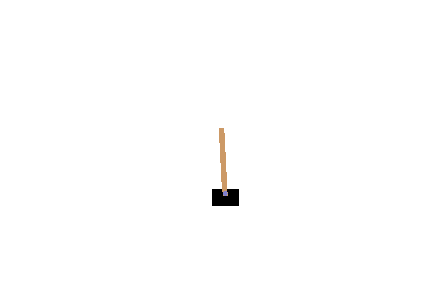
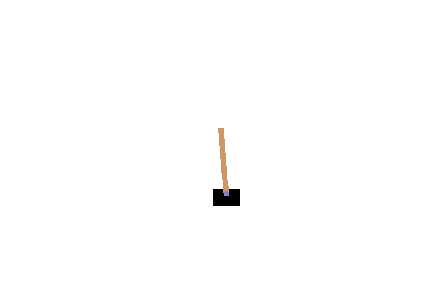
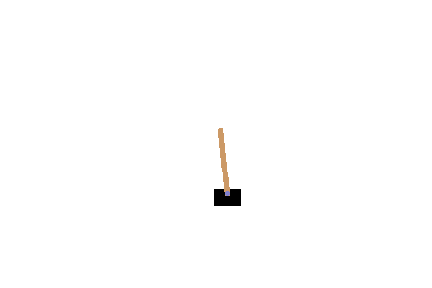
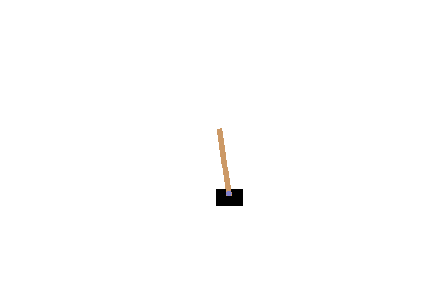
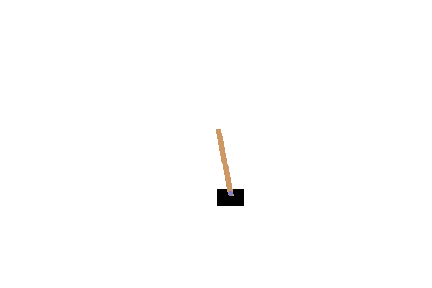

In [11]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

env = gym.make('CartPole-v0')

# Run a demo of the environment
observation = env.reset()
cum_reward = 0
frames = []
for t in range(5000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.render(close=True)
display_frames_as_gif(frames)

At every time step, you can observe its position $x$, velocity $\dot{x}$, angle $\theta$, and angular velocity $\dot{\theta}$. These are the observable states of this world. At any state, the cart only has two possible actions: move to the left or move to the right. In other words, the state-space of the Cart-Pole has four dimensions of continuous values and the action-space has one dimension of two discrete values.

The idea behing Reinforcement Learning is therefore to decide of the best action to perform according to the information given by the game's environment. In the CartPole's case, the action is either $+1$ or $-1$, indicating if the cart should go to the right or left. So, in short, there's a constant dialogue between an Agent, usually a human playing but here it will be a computer, and the Environment, here the CartPole game.

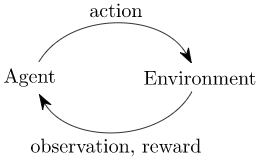

In [15]:
from IPython.display import Image
Image('Agent-Env-Loop.png')

Here comes the notion of reward. It's crucial because the Agent's role is to maximise that reward, since it's highly correlated to chance of winning the game. Here the reward will be a number between 0 and 200, 200 meaning the game was won because the pole successfully didn't fall.

We must first illustrate the math behind Q-Learning in order to program it.

Like explained in the paper, we consider the standard reinforcement learning setting where an agent interacts with an environment $E$ over a number of discrete time steps. At each time step $t$, the agent receives a state st and selects an action at from some set of possible actions $A$ according to its policy $\pi$, where $\pi$ is a mapping from states $s_t$ to actions at. In return, the agent receives the next state $s_{t+1}$ and receives a scalar reward $r_t$. The process continues until the agent reaches a terminal state after which the process restarts. The return $R_t = \sum^{\infty}_{k=0} \gamma^k r_{t+k}$ is the total accumulated return from time step $t$ with discount factor $\gamma \in [0, 1]$. The goal of the agent is to maximize the expected return from each state $s_t$.

The action value $Q^{\pi}(s, a) = \mathbb{E}[R_t|s_t = s, a]$ is the expected return for selecting action $a$ in state $s$ and following policy $\pi$. The optimal value function $Q^{∗}(s, a) = \max_{\pi} Q^{\pi}(s, a)$ gives the maximum action value for state $s$ and action $a$ achievable by any policy. Similarly, the value of state $s$ under policy $\pi$ is defined as $V^{\pi}(s) = \mathbb{E}[R_t|s_t = s]$ and is simply the expected return for following policy $\pi$ from state $s$.

All this said, Q-learning is the method that aims to directly approximate the optimal action value function: $Q^{*}(s, a) \approx Q(s, a; θ)$. In one-step Q-learning, the parameters $\theta$ of the action value function $Q(s, a; \theta) $ are learned by iteratively minimizing a sequence of loss functions, there the *i*th loss function defined as: $$L_i(\theta_i) =  \mathbb{E} \left (r + \gamma \max_{a'} Q(s',a';\theta_{i-1})-Q(s,a;\theta_i) \right ) ^2$$ 

where $s'$ is the state encountered after state $s$.

Our goal will be to implement these functions using a Deep Neural Network and compare results using GPU or not.